### Amortized Inference using `sbi`

`sbi` is one of the user-friendly Python libraries for simulation-based inference. For detailed documentation, visit https://www.mackelab.org/sbi/. The following code demonstrates how to reproduce our HCI model case study using the `sbi` library.

Like other simulation-based inference methods, amortized inference with `sbi` requires two components:

1. **A simulation model**, in our case, a user simulation model that takes parameter values (which characterize a user) and returns the simulated behavior (i.e., observation).
2. **Prior distributions** of model parameters used for sampling during simulation.

In this tutorial, we illustrate how a practitioner can invert a user model, using our menu search model case as an example.

In [1]:
import sys
sys.path.append('../')
import numpy as np
import torch

from src.simulators import MenuSimulator
from src.datasets import MenuValidDataset, MenuUserDataset
from src.utils.torch_distrib import TruncatedNormal, MixedDistribution

menu_simulator = MenuSimulator()
menu_user_dataset = MenuUserDataset()
menu_valid_dataset = MenuValidDataset()

[ simulator ] total trainable parameters : 6509
[ simulator - loaded checkpoint ]
	../src/simulators/menu/models/menu_dqn/3000K.pt


In [2]:
# Set a function of simulating user behavior
def simulate_user(parameters):
    """
    input: model parameters to simulate
    --> ndarray with sizes of (N,) or (B, N)
    --> N: no. of parameters, B: size of batch

    output: simulated behavior
    (current sbi supports an aggregated form of behavior, like performance)
    --> ndarray with sizes of (M,) or (B, M)
    --> M: dim. of behavior data, B: size of batch
    """
    _, summary_output = menu_simulator.simulate(
        sim_per_param=10000,
        fixed_params=parameters,
    )
    return summary_output

# A sample parameter set from the CHI'17 paper by Kangasrääsiö et al. 
# Each parameter represents a user's latent feature during menu search
# (details on the paper):
"""
=======
1) the duration for eye fixation
2) the duration for menu item selection
3) probability of recalling all items' information during the first fixation period
4) probability of investigating the item above or below the fixation target via peripheral vision
=======
"""
parameter_example = np.array([2.80, 0.29, 0.69, 0.93])

# The output is a 1D array with size of 4
"""
=======
1) mean value of task completion time when target is presented
2) std value of task completion time when target is presented
3) mean value of task completion time when target is absent
4) std value of task completion time when target is absent
=======
"""
simulate_user(parameter_example)

array([[0.33222874, 0.07783185, 0.17532297, 0.14318833]])

In [3]:
# Set a prior distribution for sampling the model parameters
# A sample prior distribution from the CHI'17 paper
prior = MixedDistribution([
    TruncatedNormal(loc=3.0, scale=1.0, a=0.0, b=6.0),
    TruncatedNormal(loc=0.3, scale=0.3, a=0.0, b=1.0),
    torch.distributions.Uniform(low=0.0, high=1.0),
    torch.distributions.Uniform(low=0.0, high=1.0),
])

# Or you can set an alternative prior distribution, like a uniform distribution:
#
# from sbi import utils as sbi_utils
# prior = sbi_utils.BoxUniform(
#     low=torch.zeros(4),
#     high=torch.ones(4) * torch.tensor([6., 1., 1., 1.])
# )

In [5]:
from sbi.inference.base import infer

# `infer` function from `sbi` will train a inference model 

# posterior = infer(
#     simulate_user,
#     prior,
#     "SNPE",
#     num_simulations=10000,
#     num_workers=8
# )

import os
import pickle
sys.path.append('../src/')
if os.path.exists("../data/menu/amortizer_models/sbi/snpe_50000.pkl"):
    with open("../data/menu/amortizer_models/sbi/snpe_50000.pkl", "rb") as f:
        posterior = pickle.load(f)


In [6]:
# The trained model (`posterior`) can be used to infer from actual user data
# Let's say we have a observation from a group of users
group_data_for_fitting, _ = menu_user_dataset.indiv_sample(
    cross_valid=True,
    for_pop=True,
)
print(group_data_for_fitting)

[0.33729452 0.12512302 0.179801   0.11503245]


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

inferred_params:  [2.579412  0.2718366 0.7078299 0.5542245]


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

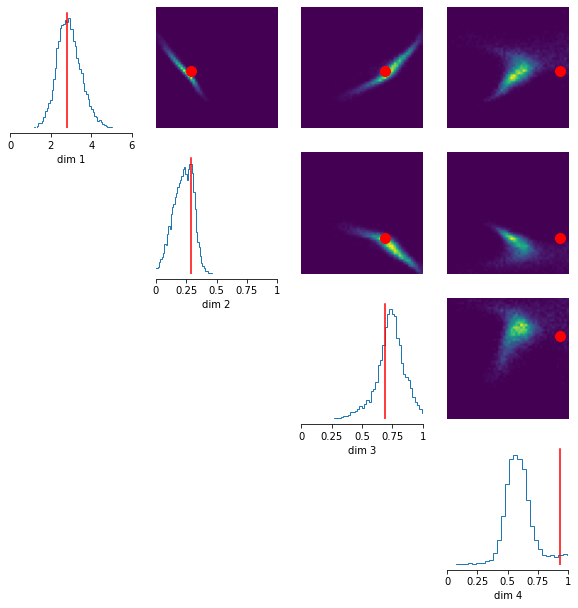

In [7]:
import matplotlib.pyplot as plt
from sbi import analysis as sbi_analysis

# `posterior` can be used to generate posterior samples and investigate their distribution
posterior.set_default_x(group_data_for_fitting)
inferred_params = posterior.map().numpy()
print("inferred_params: ", inferred_params)

n_posterior_samples = 10000
posterior_samples = posterior.sample((n_posterior_samples,))

fig, _ = sbi_analysis.pairplot(
    posterior_samples,
    points=parameter_example,
    limits=[[0., 6.], [0., 1.], [0., 1.], [0., 1.]],
    points_colors="red"
)
plt.show()
plt.close()

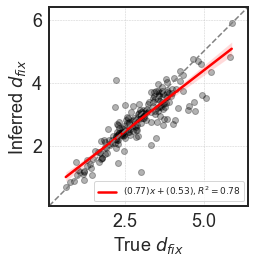

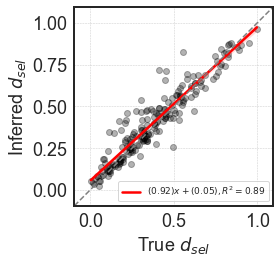

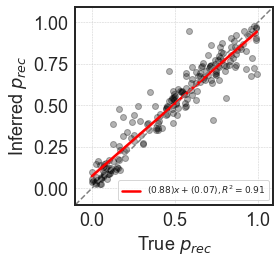

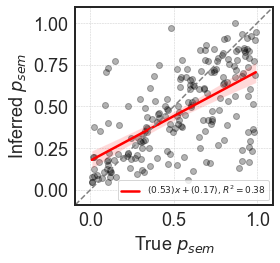

In [9]:
from sklearn.metrics import r2_score
from src.utils.plot import plot_parameter_recovery

# From the simulated dataset,
# it is also possible to how the tranined model well recover the true parameters
gt_params, valid_data = menu_valid_dataset.sample()
inferred_params = list()
for param_i in range(gt_params.shape[0]):
    posterior.set_default_x(valid_data[param_i])
    inferred_params.append(posterior.map().numpy())
inferred_params = np.array(inferred_params)

targeted_params = ["d_fix", "d_sel", "p_rec", "p_sem"]
param_symbol = ["$d_{fix}$", "$d_{sel}$", "$p_{rec}$", "$p_{sem}$"]
for param_i, param_name in enumerate(targeted_params):
    y_true = gt_params[:, param_i]
    y_pred = inferred_params[:, param_i]
    y_fit = np.polyfit(y_true, y_pred, deg=1)
    y_func = np.poly1d(y_fit)
    r_squared = r2_score(y_pred, y_func(y_true))

    plot_parameter_recovery(
        y_true,
        y_pred,
        y_fit,
        r_squared,
        fname=f"r2_{param_name}",
        param_label=param_symbol[param_i],
        fpath="../results/menu/sbi_example",
    )